In [1]:
# Import Dependancies
import hvplot.pandas
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime



In [3]:
# Create a file path for the cleaned csv file
path = 'Cleaned_Crimes_-_2016_to_present.csv'

# Read csv file with pandas
cleaned_crime_data = pd.read_csv(path, encoding='ISO-8859-1')
cleaned_crime_data.head()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,0,25953,JE240540,05/24/2021 03:06:00 PM,020XX N LARAMIE AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,True,...,36.0,19.0,01A,1141387.0,1913179.0,2021,11/18/2023 03:39:49 PM,41.917838,-87.755969,"(41.917838056, -87.755968972)"
1,1,26038,JE279849,06/26/2021 09:24:00 AM,062XX N MC CORMICK RD,0110,HOMICIDE,FIRST DEGREE MURDER,PARKING LOT,True,...,50.0,13.0,01A,1152781.0,1941458.0,2021,11/18/2023 03:39:49 PM,41.995219,-87.713355,"(41.995219444, -87.713354912)"
2,2,13279676,JG507211,11/09/2023 07:30:00 AM,019XX W BYRON ST,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,False,...,47.0,5.0,05,1162518.0,1925906.0,2023,11/18/2023 03:39:49 PM,41.952345,-87.677975,"(41.952345086, -87.677975059)"
3,3,13274752,JG501049,11/12/2023 07:59:00 AM,086XX S COTTAGE GROVE AVE,0454,BATTERY,"AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MIN...",SMALL RETAIL STORE,True,...,6.0,44.0,08B,1183071.0,1847869.0,2023,12/09/2023 03:41:24 PM,41.737751,-87.604856,"(41.737750767, -87.604855911)"
4,4,13203321,JG415333,09/06/2023 05:00:00 PM,002XX N Wells st,1320,CRIMINAL DAMAGE,TO VEHICLE,PARKING LOT / GARAGE (NON RESIDENTIAL),False,...,42.0,32.0,14,1174694.0,1901831.0,2023,11/04/2023 03:40:18 PM,41.886018,-87.633938,"(41.886018055, -87.633937881)"


# New code by quinns_branch
## Plotting Hot Spots
#### Step 1: Find the value to search

In [20]:
# Group by 'Primary Type' and get the count of each primary type
top_4_crimes = cleaned_crime_data.groupby('Primary Type').size()

# Sort values in ascending order and reassign into a list to reference
top_4_crimes = top_4_crimes.sort_values(ascending=True)

# Get only the top 4 crimes
top_4_crimes = top_4_crimes[-4:]

# Convert the Series into a DataFrame and reset the index
top_4_crimes_df = top_4_crimes.reset_index(name='Total Incidents')

# Print the new DataFrame
print(f"You want to find a specific value which is one of these options:")
top_4_crimes_df

You want to find a specific value which is one of these options:


,Primary Type,Total Incidents
0,ASSAULT,179954
1,CRIMINAL DAMAGE,243963
2,BATTERY,402701
3,THEFT,489381


In [21]:
# Input the specific value you want to analyze
specific_value = 'assault' # You can capitalized the specific value if you want

# Define your Primary Type
prim_type = cleaned_crime_data[cleaned_crime_data['Primary Type'] == f'{specific_value.upper()}'].copy()  # ASSAULT is the specific value I want to find

#### Step 2: Start setting up plotting variables
Now, with both the specific value to search defined and the new filtered pandas DataFrame, we can start to work on getting datetime set up to follow Ian's brilliant code

In [22]:
# We need to convert 'Date' column to datetime
prim_type['Date'] = pd.to_datetime(prim_type['Date'], format='%m/%d/%Y %I:%M:%S %p')

In [23]:
# Next, define pandemic periods
prim_type['Pandemic Period'] = pd.cut(
    prim_type['Date'],
    bins=[
        pd.Timestamp('2017-01-01'),
        pd.Timestamp('2020-01-31'),
        pd.Timestamp('2023-05-11'),
        pd.Timestamp('2024-10-25'),
    ],
    labels=['Before Pandemic', 'During Pandemic', 'After Pandemic'],
    right = False # This makes the right edge of each bin exclusive 
)
# Basic stats and summary by period
print(prim_type.info())
print(prim_type.groupby('Pandemic Period').size())

# Filter data for relevant columns
crime_location_data = prim_type[['Date', 'Primary Type', 'Block', 'Latitude', 'Longitude', 'Pandemic Period']].dropna()

crime_location_data = crime_location_data[
    (crime_location_data['Latitude'] != 0.0) & # Removes any undifined/missing latitude values
    (crime_location_data['Longitude'] != 0.0) & # Removes any undifined/missing longitude values
    (crime_location_data['Latitude'] > 37.0) # Removes unfortunate outlier
]

<class 'pandas.core.frame.DataFrame'>
Index: 179954 entries, 31 to 2171282
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Unnamed: 0            179954 non-null  int64         
 1   ID                    179954 non-null  int64         
 2   Case Number           179954 non-null  object        
 3   Date                  179954 non-null  datetime64[ns]
 4   Block                 179954 non-null  object        
 5   IUCR                  179954 non-null  object        
 6   Primary Type          179954 non-null  object        
 7   Description           179954 non-null  object        
 8   Location Description  179954 non-null  object        
 9   Arrest                179954 non-null  bool          
 10  Domestic              179954 non-null  bool          
 11  Beat                  179954 non-null  int64         
 12  District              179954 non-null  float64       
 13  Wa

C:\Users\qjone\AppData\Local\Temp\ipykernel_115300\3862481680.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(prim_type.groupby('Pandemic Period').size())


Analyzing data for ASSAULT incidents that occurred Before Pandemic



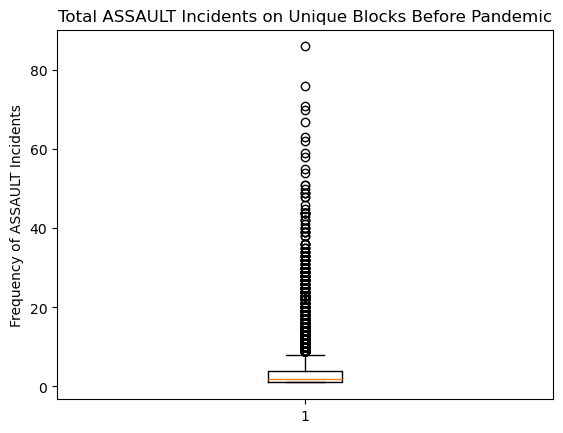

The lower quartile of ASSAULT incidents is: 1.0
The upper quartile of ASSAULT incidents is: 4.0
The interquartile range of ASSAULT incidents is: 3.0
The last quantile (0.75) of ASSAULT incidents is: 4.0
Values below -3.5 could be outliers.

IMPORTANT:

This is the outlier data, which we will need to calculate hot spots.
Thus, blocks with values above 8.5 are data points that we need to filter.
Analyzing data for ASSAULT incidents that occurred During Pandemic



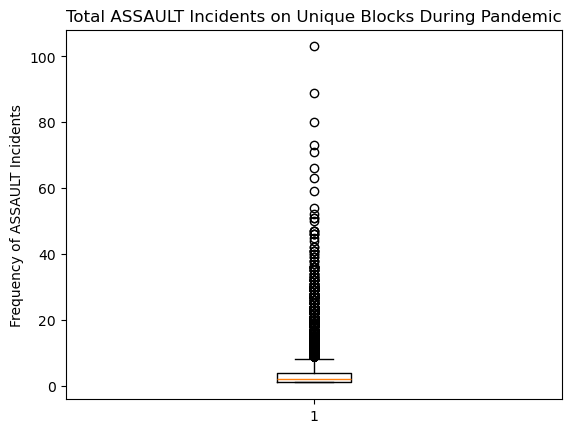

The lower quartile of ASSAULT incidents is: 1.0
The upper quartile of ASSAULT incidents is: 4.0
The interquartile range of ASSAULT incidents is: 3.0
The last quantile (0.75) of ASSAULT incidents is: 4.0
Values below -3.5 could be outliers.

IMPORTANT:

This is the outlier data, which we will need to calculate hot spots.
Thus, blocks with values above 8.5 are data points that we need to filter.
Analyzing data for ASSAULT incidents that occurred After Pandemic



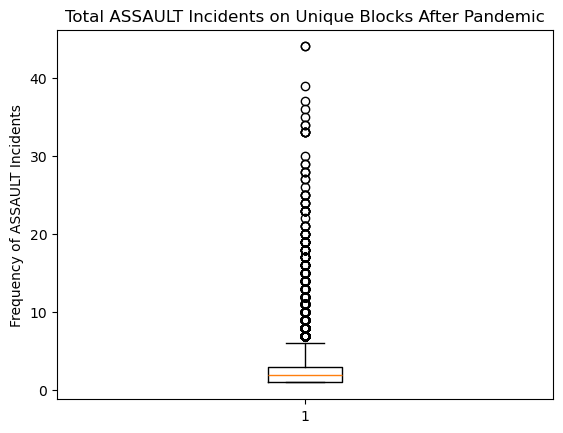

The lower quartile of ASSAULT incidents is: 1.0
The upper quartile of ASSAULT incidents is: 3.0
The interquartile range of ASSAULT incidents is: 2.0
The last quantile (0.75) of ASSAULT incidents is: 3.0
Values below -2.0 could be outliers.

IMPORTANT:

This is the outlier data, which we will need to calculate hot spots.
Thus, blocks with values above 6.0 are data points that we need to filter.


In [24]:
# Define the order of the periods explicitly (to ensure correct ordering)
period_order = ['Before Pandemic', 'During Pandemic', 'After Pandemic']

# Initialize a dictionary to store hotspot values for each period
outliers_dict = {}

# Loop through each period label in the defined order
for period in period_order:
    print(f"Analyzing data for {specific_value.upper()} incidents that occurred {period}\n")
    
    # Filter the data for the current period
    period_data = crime_location_data[crime_location_data['Pandemic Period'] == period]

    # Check the total of the unique value counts for each block during this period
    unique_counts = period_data['Block'].value_counts()
    
    # I commented out this line of code to make the output less cluttered
    # print(f"Unique counts for each block where {specific_value.upper()} incidents occurred {period}:\n{unique_counts}\n")

    # Make a boxplot for the outlier values during this period.
    fig1, ax1 = plt.subplots()

    # This sets the Title to the specific value I want to find
    ax1.set_title(f'Total {specific_value.upper()} Incidents on Unique Blocks {period}')  # Title includes period

    # Set the 'y' label to a descriptive text about the count of incidents
    ax1.set_ylabel(f"Frequency of {specific_value.upper()} Incidents")

    # Display a box plot of the unique counts for the period
    ax1.boxplot(unique_counts)
    plt.show()

    # Calculate Quartile Values for a Boxplot
    quartiles = unique_counts.quantile([0.25, 0.5, 0.75, 1.0])
    lowerq = quartiles[0.25]  # Lower quartile
    upperq = quartiles[0.75]  # Upper quartile
    iqr = upperq - lowerq     # Interquartile range

    # Calculate bounds for outliers
    lower_bound = lowerq - (1.5 * iqr)
    upper_bound = upperq + (1.5 * iqr)

    # Print combined output for quartile calculations
    print(
        f"The lower quartile of {specific_value.upper()} incidents is: {lowerq}\n"
        f"The upper quartile of {specific_value.upper()} incidents is: {upperq}\n"
        f"The interquartile range of {specific_value.upper()} incidents is: {iqr}\n"
        f"The last quantile (0.75) of {specific_value.upper()} incidents is: {quartiles[0.75]}"
    )

    # Print combined output for outlier calculations
    print(
        f"Values below {lower_bound} could be outliers.\n"
        f"\nIMPORTANT:\n"
        f"\nThis is the outlier data, which we will need to calculate hot spots.\n"
        f"Thus, blocks with values above {upper_bound} are data points that we need to filter."
    )
    
    # Input hotspot value into a dictionary for each period
    outliers_dict[period] = upper_bound

    # Filter period data to keep only rows where block counts are above the upper bound
    hotspot_blocks = unique_counts[unique_counts > upper_bound].index
    period_outliers_df = period_data[period_data['Block'].isin(hotspot_blocks)]

    # Assign this DataFrame to a variable named according to the period
    globals()[f"{period.replace(' ', '_')}_outliers_df"] = period_outliers_df

    print("="*75)  # Separator between different periods

In [25]:
# Check the outliers dictionary has the correct vlaues for later filtering
print(outliers_dict)

{'Before Pandemic': 8.5, 'During Pandemic': 8.5, 'After Pandemic': 6.0}


In [26]:
# Check new that new pandas DataFrame exists
During_Pandemic_outliers_df.head()

,Date,Primary Type,Block,Latitude,Longitude,Pandemic Period
4795,2022-02-17 20:00:00,ASSAULT,071XX S HALSTED ST,41.764282,-87.644389,During Pandemic
6317,2023-03-06 06:35:00,ASSAULT,111XX S MICHIGAN AVE,41.691372,-87.621035,During Pandemic
12802,2023-04-22 20:59:00,ASSAULT,065XX S LOWE AVE,41.775430,-87.640753,During Pandemic
18855,2021-12-18 15:47:00,ASSAULT,030XX E CHELTENHAM PL,41.752956,-87.550518,During Pandemic
33019,2022-06-12 15:30:00,ASSAULT,063XX S MOZART ST,41.778104,-87.694582,During Pandemic


#### Step 4: Get the outlier values of the new outlier dataframes 
Because these data points would be the outliers of the outliers, I think that we can define them as "**Hot Spots**"

Analyzing data for ASSAULT incidents that occurred Before Pandemic



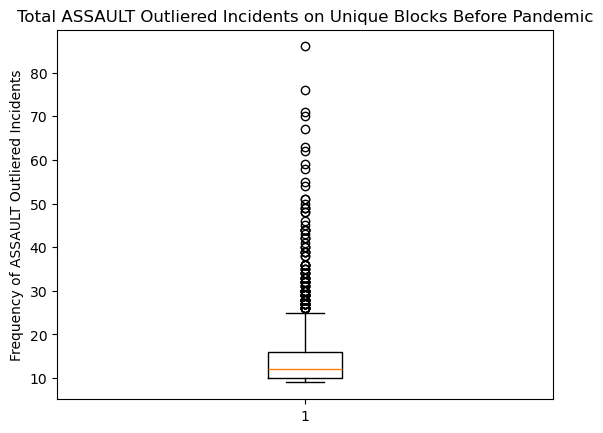

The lower quartile of ASSAULT incidents is: 10.0
The upper quartile of ASSAULT incidents is: 16.0
The interquartile range of ASSAULT incidents is: 6.0
The last quantile (0.75) of ASSAULT incidents is: 16.0
Values below 1.0 could be outliers.

IMPORTANT:

This is the data that I think defines a 'Hot Spot', which is going to be all values that are the outliers of the outliers.
Thus, blocks with values above 25.0 are data points that we can now define as 'hot spots'.
Analyzing data for ASSAULT incidents that occurred During Pandemic



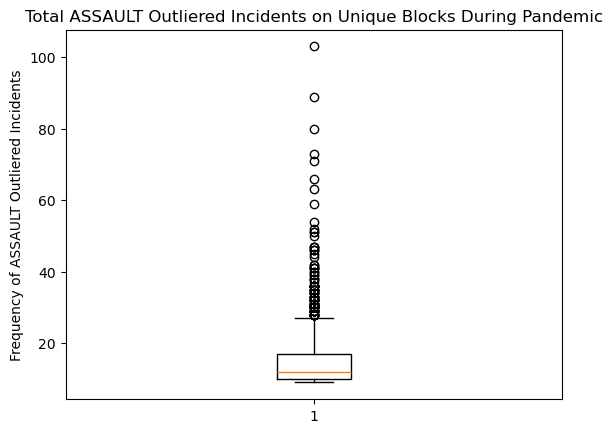

The lower quartile of ASSAULT incidents is: 10.0
The upper quartile of ASSAULT incidents is: 17.0
The interquartile range of ASSAULT incidents is: 7.0
The last quantile (0.75) of ASSAULT incidents is: 17.0
Values below -0.5 could be outliers.

IMPORTANT:

This is the data that I think defines a 'Hot Spot', which is going to be all values that are the outliers of the outliers.
Thus, blocks with values above 27.5 are data points that we can now define as 'hot spots'.
Analyzing data for ASSAULT incidents that occurred After Pandemic



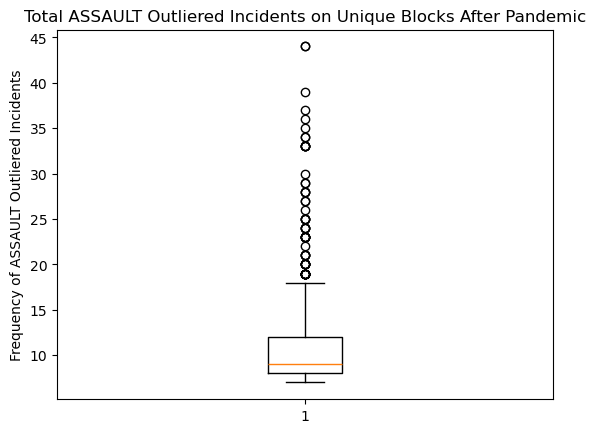

The lower quartile of ASSAULT incidents is: 8.0
The upper quartile of ASSAULT incidents is: 12.0
The interquartile range of ASSAULT incidents is: 4.0
The last quantile (0.75) of ASSAULT incidents is: 12.0
Values below 2.0 could be outliers.

IMPORTANT:

This is the data that I think defines a 'Hot Spot', which is going to be all values that are the outliers of the outliers.
Thus, blocks with values above 18.0 are data points that we can now define as 'hot spots'.


In [40]:
# Define the order of the periods explicitly (to ensure correct ordering)
period_order = ['Before_Pandemic_outliers_df', 'During_Pandemic_outliers_df', 'After_Pandemic_outliers_df']

# Initialize a dictionary to store hotspot values for each period
hotspots_dict = {}

# Loop through each period-specific outlier DataFrame
for period_df_name in period_order:
    # Retrieve the DataFrame by its name (e.g., Before_Pandemic_outliers_df)
    period_data = globals().get(period_df_name)
    
    if period_data is not None:
        period_label = period_df_name.replace('_outliers_df', '').replace('_', ' ')  # Cleaned-up period name for display
        print(f"Analyzing data for {specific_value.upper()} incidents that occurred {period_label}\n")

        # Calculate the unique value counts for each block within this period-specific DataFrame
        ##
        unique_counts = period_data['Block'].value_counts()

        # Create a boxplot for the outlier values in this period
        fig1, ax1 = plt.subplots()

        # This sets the title to the specific value you want to find
        ax1.set_title(f'Total {specific_value.upper()} Outliered Incidents on Unique Blocks {period_label}')  # Title includes period
        ax1.set_ylabel(f"Frequency of {specific_value.upper()} Outliered Incidents")
        ax1.boxplot(unique_counts)
        plt.show()

        # Calculate Quartile Values for a Boxplot
        quartiles = unique_counts.quantile([0.25, 0.5, 0.75, 1.0])
        lowerq = quartiles[0.25]  # Lower quartile
        upperq = quartiles[0.75]  # Upper quartile
        iqr = upperq - lowerq     # Interquartile range

        # Calculate bounds for outliers
        lower_bound = lowerq - (1.5 * iqr)
        upper_bound = upperq + (1.5 * iqr)

        # Print combined output for quartile calculations
        print(
            f"The lower quartile of {specific_value.upper()} incidents is: {lowerq}\n"
            f"The upper quartile of {specific_value.upper()} incidents is: {upperq}\n"
            f"The interquartile range of {specific_value.upper()} incidents is: {iqr}\n"
            f"The last quantile (0.75) of {specific_value.upper()} incidents is: {quartiles[0.75]}"
        )

        # Print combined output for outlier calculations
        print(
            f"Values below {lower_bound} could be outliers.\n"
            f"\nIMPORTANT:\n"
            f"\nThis is the data that I think defines a 'Hot Spot', which is going to be all values that are the outliers of the outliers.\n"
            f"Thus, blocks with values above {upper_bound} are data points that we can now define as 'hot spots'."
        )
        
        # Input hotspot value into a dictionary for each period
        hotspots_dict[period_label] = upper_bound

        # Filter period data to keep only rows where block counts are above the upper bound
        hotspot_blocks = unique_counts[unique_counts > upper_bound].index
        hotspots_df = period_data[period_data['Block'].isin(hotspot_blocks)]
        
        # Store the filtered DataFrame back into globals for further analysis if needed
        globals()[f"{period_label.replace(' ', '_')}_hotspot_outliers_df"] = hotspots_df

        print("=" * 75)  # Separator between different periods


In [41]:
After_Pandemic_hotspot_outliers_df.head()

,Date,Primary Type,Block,Latitude,Longitude,Pandemic Period
470,2023-09-07 00:00:00,ASSAULT,040XX W 26TH ST,41.844253,-87.724944,After Pandemic
720,2024-08-25 21:36:00,ASSAULT,023XX W JACKSON BLVD,41.877567,-87.684714,After Pandemic
879,2024-08-25 18:16:00,ASSAULT,091XX S COMMERCIAL AVE,41.729544,-87.551245,After Pandemic
1462,2024-08-25 11:14:00,ASSAULT,037XX W CHICAGO AVE,41.895421,-87.720539,After Pandemic
1726,2023-09-07 08:45:00,ASSAULT,002XX E HURON ST,41.895003,-87.621528,After Pandemic


#### Step 4: Plot the newly defined "**Hot Spots**"
Now that we have our hot spots defined it is time to plot them on charts

In [42]:
# Initialize a dictionary for storing the filtered hotspot DataFrames
hotspot_dfs = {}

# Loop through each period-specific outlier DataFrame to generate maps
for period_df_name in period_order:
    # Retrieve the DataFrame by its name (e.g., Before_Pandemic_outliers_df)
    period_data = globals().get(period_df_name)
    
    if period_data is not None:
        period_label = period_df_name.replace('_outliers_df', '').replace('_', ' ')  # Cleaned-up period name for display
        print(f"Mapping Chicago hotspots for {specific_value.upper()} incidents during {period_label}\n")

        # Calculate unique value counts for each 'Block' in this period-specific DataFrame
        unique_counts_plot = period_data['Block'].value_counts()

        # Get the threshold from hotspots_outliers_dict for this period
        threshold = hotspots_dict.get(period_label)

        # Filter period data to keep only rows where block counts are above the threshold
        hotspot_blocks = unique_counts_plot[unique_counts_plot > threshold].index
        filtered_period_data = period_data[period_data['Block'].isin(hotspot_blocks)]

        # Store the filtered DataFrame in hotspot_dfs dictionary for reference
        hotspot_dfs[period_label] = filtered_period_data

        # Plotting hotspots using hvplot
        # Calculate sizes based on unique counts for scaled visual effect
        filtered_period_data['Point Size'] = filtered_period_data['Block'].map(unique_counts_plot) * 1.5 # Increase the value if hotspots are not well displayed

        # Display map-based plot for Chicago hotspots with `hvplot.points`
        map_plot = filtered_period_data.hvplot.points(
            'Longitude', 'Latitude', 
            geo=True, tiles='CartoLight',  # Enable map background
            color='blue', alpha=0.3,
            size='Point Size',  # Size points based on frequency
            title=f"Chicago {specific_value.upper()} Hot Spots {period_label}",
            xlabel="Longitude", ylabel="Latitude",
            frame_width=800, frame_height=600
        )
        display(map_plot)  # Use display to render hvplot in Jupyter notebooks if needed

        print('=' * 150)  # Separator between different charts

Mapping Chicago hotspots for ASSAULT incidents during Before Pandemic



C:\Users\qjone\AppData\Local\Temp\ipykernel_115300\1473569640.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_period_data['Point Size'] = filtered_period_data['Block'].map(unique_counts_plot) * 1.5 # Increase the value if hotspots are not well displayed
c:\Users\qjone\anaconda3\envs\dev\lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (Point Size)

Mapping Chicago hotspots for ASSAULT incidents during During Pandemic



C:\Users\qjone\AppData\Local\Temp\ipykernel_115300\1473569640.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_period_data['Point Size'] = filtered_period_data['Block'].map(unique_counts_plot) * 1.5 # Increase the value if hotspots are not well displayed


:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (Point Size)

Mapping Chicago hotspots for ASSAULT incidents during After Pandemic



C:\Users\qjone\AppData\Local\Temp\ipykernel_115300\1473569640.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_period_data['Point Size'] = filtered_period_data['Block'].map(unique_counts_plot) * 1.5 # Increase the value if hotspots are not well displayed


:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (Point Size)